<h2 style="text-align: center;">Illumination with Reflection for Spheres: Updated</h2>
<h3 style="text-align: center;">Ross Beveridge, October 26, 2017</h3>
<p>In this Notebook is a full implementation of ambient, diffuse and specular reflection - in color - for a scene consisting multiple light sources and multiple spheres.  Also in this Notebook is an example of recursive ray tracing. In other words, one object may be seen to reflect on the surface of another.</p>
<p>THis notebook is similar released on October 24. However, at least one minor bug has been fixed. Also, a few nods to efficiency have been added as well as some clearning in the illumination computation.</p>
<p>The first bit of code that follows is book keeping to help setup libraries and display defaulst.  Read on below to get more about the substance of this ray tracer.</p>

In [1]:
import numpy as np
from sage.repl.image import Image
from sage.plot.plot3d.shapes import *
from sage.plot.plot3d.base import SHOW_DEFAULTS
SHOW_DEFAULTS['aspect_ratio'] = (1,1,1)
SHOW_DEFAULTS['frame_aspect_ratio'] = (1,1,1)
SHOW_DEFAULTS['perspective_depth'] = false

<p>Earlier versions of this worksheet attempted to avoid full on Object Oriented Programming.  Afterall, the purpose of these Notebooks are simple illustrations rather than complete programs.  </p>
<p>However, there comes a point, and illuminating a multiple object scene with multiple light sources and with recursive ray tracing, where it is better to adimt this Notebook is a program of moderate complexity. Thereore, much of the start of this Notebook is setting up object classes to make the rest of the illustration simple.</p>
<p>The first object class models a camera.  Note that the three camera basis vectors are now calcculated as part of object construction. These vectors are constructed based upon any value sequence of three numbers passed into the constructor.</p>
<p>Also important for efficiency reasons is the inclusion and use of the numpy python library.  While the SageMath array and vector classes are handy for many purposes, most particularly mixing symbolic and numeric computation, this generality comes with a performance hit. </p>
<p>Another minor design choice.  The left, right, bottom and top bounds of the image plane are passed into the constructor as a tuple but then unpacked to make access to the min-max bounds on each dimension easier.</p>

In [2]:
def make_unit(x) :
    return x / np.linalg.norm(x)
    
class Camera :
    def __init__(self, eye, look, up, bnds, near, far, width, height) :
        self.eye   = np.array(eye)
        self.look  = np.array(look)
        self.up    = np.array(up)
        self.umin  = bnds[0]
        self.umax  = bnds[1]
        self.vmin  = bnds[2]
        self.vmax  = bnds[3]
        self.near  = near
        self.far   = far
        self.width = width
        self.height = height
        self.setupUVW()
        
    def setupUVW(self) :
        Wv = make_unit(self.eye - self.look)   
        Uv = make_unit(np.cross(self.up, Wv))    
        self.V = np.cross(Wv,Uv)
        self.U = Uv
        self.W = Wv

<p>The object class used for spheres is named 'globe' in order to avoid name collisions.  In particular, there is already a sphere function defined in the context of 3D graphics.  Note the relationship between spheres and materials is captured by an integer index into a materials list. Hence, each globe includes this 'pointer' to the globe's material properties in the form of an integer index.   </p>
<p>The material object stores the illumination constants which in turn determine the visual appearance of a material.  The first three are standard: ambient, diffuse and specular.  The last is the reflection constant. It generally is used to attenuate the strength of reflections during successive recursive calls.  </p>
<p>The lights include a location and also an illumination strength - intensity</p>

In [3]:
class Globe :
    def __init__(self, c, r, m) :
        self.C = np.array(c)       # Sphere center as a vector
        self.r = float(r)          # Sphere radius
        self.m = m                 # Index for sphere's material

class Material : 
    def __init__(self, a, d, s, r) :
        self.ka = np.array(a)
        self.kd = np.array(d)
        self.ks = np.array(s)
        self.kr = np.array(r)
       
class Light :
    def __init__(self, p, e) :
        self.P = np.array(p)
        self.E = np.array(e)

<p>The ray class follows our standard definition of a ray as point of origination, L, and a direction D. </p>
<p>The ray object also provides a means of keeping track of the closet sphere yet found.  </p>
<p>There are a variety of ways to think about this process, but perhaps the simplest is caching. Much of the work done in ray tracing involves finding interesections between rays and obejcts; after going to all that effort, it is wise to keep the best result.  In other words the closest object.  Note the initialization value for the best - i.e. closest - sphere is None and remains none if that paticular ray never intersects a sphere.  </p>

In [4]:
class Ray :
    def __init__(self, L, D) :
        self.L = np.array(L)
        self.D = make_unit(np.array(D))
        self.best_t   = float('inf')
        self.best_sph = None
        self.best_pt  = None
       
    def sphere_test(self, sph) :
        Tv   = np.array(sph.C - self.L)
        v    = np.dot(Tv, self.D)
        csq  = np.dot(Tv, Tv)
        disc = sph.r^2 - (csq - v^2)
        if (disc > 0) :
            tval = v - sqrt(disc)
            if (tval < self.best_t) and (tval > 0.00001) :
                self.best_t   = tval
                self.best_sph = sph
                self.best_pt  = self.L + tval * self.D       
            return True
        else :
            return False

<h2 style="text-align: center;">Customizable Scene Description</h2>
<p>The actual instanciations of cameras, lights, materials and objects follow.  </p>
<p>There are two cameras intensionally identical up to, but not include, pixel resolution.  This allow the Notebook to provide an interactive 3D model of the entire scene as well as to render at a typically much higher resolution ray traced scene.</p>
<p>The scene is described by a combination of one ambient light source, a list of point light sources, a list of materials and a list of objects. All of these, materials, lights and objects, are implemented using the classes defined above. </p>

In [5]:
# There are two versions of the camera, identical but for resolution. First is for
# 3D model and the second is for using ray tracing to produce the ray traced image.
#
# The next camera creates a square image with all three globes in view
cam1 = Camera((50,50,100),(50,50,10),(0,1,0),(-2.5,2.5,-2.5,2.5),-5,-100,8,8)
# The next camera tightens the field of view to show mostly the center globe. 
# cam1 = Camera((50,50,75),(50,50,10),(0,1,0),(-1.8,1.8,-1.8,1.8),-5,-100,8,8)

cam2 = copy(cam1); 
cam2.width  = 256
cam2.height = 256

mats = [Material((0.2, 0.2, 0.2),(1.0, 1.0, 1.0),(0.5, 0.5, 0.5),(0.9, 0.9, 0.9)),
        Material((0.7, 0.6, 0.2),(0.7, 0.6, 0.2),(0.5, 0.5, 0.5),(0.9, 0.9, 0.9)),
        Material((0.2, 0.7, 0.2),(0.2, 0.7, 0.2),(0.5, 0.5, 0.5),(0.9, 0.9, 0.9))] 
        
lgts = [Light((10,10,100),(0.5, 0.5, 0.5)),Light((90,90,100),(0.5, 0.5, 0.5))] 
#lgts = [Light((10,10,100),(0.5, 0.5, 0.5))] 
#ambi = vector(RR, 3, (0.2, 0.2, 0.2))          
ambi = vector(RR, 3, (0.0, 0.0, 0.0))    
        
objs = [Globe((50,50,20), 18, 0), Globe((32,68,42), 9, 1), Globe((68,32,42), 9, 2)]

<p>Visualizing in 3D the relative position of different objects, light sources, and the camera can be difficult.  Here the power of the Sage Notebook 3D drawing package is utilized to setup a 3D model of the scene.</p>
<p>A small point about naming conventions used here: the text 'go_' infront of a variable name means 'graphics object' and 'gol' means graphics object list.  This naming convention helps keep distinct the objects being drawn as part of the 3D scene visualization as opposed to objects directly associated with ray recursive ray tracing that follows the 3D visualization.</p>

In [6]:
def pixel_ray(i, j, c) :
    px = RR(i/(c.width  - 1)*(c.umax - c.umin) + c.umin)
    py = RR(j/(c.height - 1)*(c.vmax - c.vmin) + c.vmin)
    Lv = c.eye + (c.near * c.W) + (px * c.U) + (py * c.V)
    Dv = Lv - c.eye
    return Ray(Lv, Dv)
    
def gol_axes(gbox) :
    im3  = identity_matrix(3)
    bmin = [gbox[0] * x for x in im3.rows()]
    bmax = [gbox[1] * x for x in im3.rows()]
    rgba = ['red', 'green', 'blue']
    return [line3d([bmin[i], bmax[i]], color=rgba[i], thickness=5) for i in range(3)]   
      
def go_ray(r) :
    rayfar = r.L + r.D * abs((cam1.far - cam1.near))
    return [point(r.L, size=10), arrow3d(r.L, rayfar, width=4,color='orange')]
    
def go_globe(i) :
    mcolor = mats[objs[i].m].kd
    return Sphere(objs[i].r,color=Color(list(mats[objs[i].m].kd))).translate(objs[i].C)

<p>The next 3D visualization is extermely hepful as you try to work out in your head the relationships between the camera field of view, the object, and the light sources. Note the pixel resolution, typically 8x8, used in this 3D interactive fgure comes from camera object number one.</p>

In [7]:
rays       = [pixel_ray(i,j,cam1) for i in range(cam1.width) for j in range(cam1.height)]
gol_rays   = [e for sub in map(go_ray, rays) for e in sub]
go_eye     = point(cam1.eye, color='magenta', size=16)
gol_globes = [go_globe(i) for i in range(len(objs))]
gol_lights = [point(lgts[i].P, color=Color(list(lgts[i].E)),size=16) for i in range(len(lgts))]
figcon  = go_eye + sum(gol_rays) + sum(gol_globes) + sum(gol_lights) + sum(gol_axes((0,100)))
figcon.show()

Graphics3d Object

<p>The code below is the heart of the multi-object (spheres) ray tracing algorithm.   The first function take an argument which is a list where results of the test for intersection with a single ray and object (sphere) is stored. </p>
<p>The ray trace function takes four arguments:</p>
<ul>
<li>The first is a ray.  </li>
<li>The second is a vector to which red, green and blue illumination is added.  Initial call should set to np.array([0.0, 0.0, 0.0]).</li>
<li>The third is a reflection attenuation.  For a ray leaving a pixel the attenutation is vector(RR, 3,  (1.0, 1.0, 1.0)).  Otherwise it will be the refection constants for the material.</li>
<li>The fourth is a reflection level, i.e. a counter used to terminate recursion after say one 'bounce', two 'bounces, etc.  </li>
</ul>
<p>In this Notebook the scene properties are treated as global properties.  </p>
<p>The logic inside ray trace may be summarizes as:</p>
<ul>
<li>Find closest surface to intersect ray, if any.  If no intersection leave the color accumulator unchanged and return.</li>
<li>Calcualte the ambient, diffuse and specular illumination components for the point of intersection.  Add these to the color accumulator.</li>
<li>Test if the recursion level is greater than zero, and if so call ray trace with level decremented and the reflection attenutation multiplied by the reflection constants for the current material. </li>
</ul>
<p>As a convenience the ray trace function always returns the color accumulator.  Note this is handy if the initial value is built in the first call. However, if the color accumulator is named and used by name in the first call this return feature is not necessary. </p>

In [8]:
def ray_find(ray) :
    for s in objs :
        ray.sphere_test(s)
    return ray.best_sph
    
def ray_trace(ray, accum, refatt, level) :
    if (ray_find(ray) != None) :
        N   = make_unit(ray.best_pt - ray.best_sph.C)
        mat = mats[ray.best_sph.m]
        color = ambi * mat.ka
        toC = -1 * ray.D
        for lt in lgts :    
            toL   = make_unit(lt.P - ray.best_pt)  
            NdotL = np.dot(N,toL)
            if (NdotL > 0.0) :
                color += mat.kd * lt.E * NdotL
                spR  = make_unit((2 * NdotL * N) - toL)
                CdR  = np.dot(toC, spR)
                if (CdR > 0.0) :
                    color += (mat.ks * lt.E) * CdR**16
        for i in range(3) : accum[i] += refatt[i] * color[i]
        if (level > 0) :
            refR = make_unit((2 * np.dot(N, toC) * N) - toC)
            ray_trace(Ray(ray.best_pt, refR), accum, mat.kr * refatt, (level - 1))
    return accum

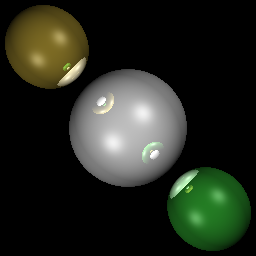

In [9]:
import profile
recursion_depth = 2
def render() :
    img = Image('RGB', (cam2.width, cam2.height), 'black')
    pix = img.pixels()
    rgb = np.array([0.0, 0.0, 0.0])
    att = np.array([1.0, 1.0, 1.0])
    for i in range(cam2.width) :
        for j in range(cam2.height) :
            ray = pixel_ray(i, (cam2.height - j -1), cam2)
            rgb[0:3] = 0.0
            att[0:3] = 1.0
            ray_trace(ray, rgb, att, recursion_depth)
            pix[i,j] = tuple(map(lambda(x) : ZZ(max(0,min(255,round(255.0 * x)))), rgb))
    return img
#profile.run('render()')
res = render()
res